In [ ]:
import numpy as np
import pandas as pd

import cv2
from pathlib import Path

import matplotlib.pyplot as plt

from tqdm import tqdm
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops
from sklearn.preprocessing import LabelEncoder

import os, glob, random



In [2]:
def get_rgb(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def get_hsv(path):
    img = cv2.imread(path)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    return hsv

def get_gray(path):
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return gray

def get_green_coverage(img_):
    green_mask = (img_[:, :, 1] > img_[:, :, 0]) & (img_[:, :, 1] > img_[:, :, 2])
    return green_mask.sum() / green_mask.size

def get_sobel(gray_, ksize = 3):
    sobelx  = cv2.Sobel(gray_, cv2.CV_64F, 1, 0, ksize=ksize)
    sobely  = cv2.Sobel(gray_, cv2.CV_64F, 0, 1, ksize=ksize)
    return np.sqrt(sobelx**2 + sobely**2)

def get_canny(gray_, low_threshold = 100, high_threshold = 200): 
    return cv2.Canny(gray_, low_threshold, high_threshold) 
    
def get_binary(gray, threshold = 127):
    _, binary = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)
    return binary 
 
def get_lbp(gray_, p = 8, r = 3, method = "uniform"):
    return local_binary_pattern(gray_, P=p, R=r, method=method)

def resized_img(img): 
    return cv2.resize(img, (256, 256))
    
def get_contours(binary):
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

def get_glcm(gray_, distance = 1, angle = [0, np.pi/4, np.pi/2, 3*np.pi/4], levels = 256, symmetric = True, normed = True):
    return graycomatrix(gray_, distances=[distance], angles=angle, levels=levels, symmetric=symmetric, normed=normed)

def get_glcm_prop(gray_):
    glcm = get_glcm(gray_)
    
    features = {}

    features['contrast']      = graycoprops(glcm, 'contrast').mean()
    features['dissimilarity'] = graycoprops(glcm, 'dissimilarity').mean()
    features['homogeneity']   = graycoprops(glcm, 'homogeneity').mean()
    features['energy']        = graycoprops(glcm, 'energy').mean()
    features['correlation']   = graycoprops(glcm, 'correlation').mean()
    features['ASM']           = graycoprops(glcm, 'ASM').mean()
    features['entropy']       = graycoprops(glcm, 'entropy').mean()

    return features


In [3]:
def update_features(path_):

    all_features = {}

    all_features.update(get_rgb_hsv_features(path_))
    all_features.update(get_texture_features(path_))
    all_features.update(get_glcm_features(path_))

    return all_features

def get_rgb_hsv_features(path_):
    features = {}

    rgb_img = get_rgb(path_)
    hsv_img = get_hsv(path_)

    for i , channel in enumerate(['r', 'g', 'b']):
        features[f'{channel}_mean']     = rgb_img[:, :, i].mean()
        features[f'{channel}_median']   = np.median(rgb_img[:, :, i])
        features[f'{channel}_std']      = rgb_img[:, :, i].std()
    
    features['green_coverage'] = get_green_coverage(rgb_img); del rgb_img

    for i , channel in enumerate(['hue', 'sat', 'val']):
        features[f'{channel}_mean']     = hsv_img[:, :, i].mean()
        features[f'{channel}_std']      = hsv_img[:, :, i].std()
    
    del hsv_img    
    return features     

def get_texture_features(path_):
    features = {}

    gray_img    = get_gray(path_)
    sobel_img   = get_sobel(gray_img)
    canny_img   = get_canny(gray_img)
    binary_img  = get_binary(gray_img)
    lbp_img     = get_lbp(resized_img(gray_img))

    features['sobel_mean']  = sobel_img.mean()
    features['sobel_std']   = sobel_img.std(); del sobel_img

    features['canny_mean']  = canny_img.mean()
    features['canny_std']   = canny_img.std(); del canny_img

    features['binary_mean'] = binary_img.mean()
    features['binary_std']  = binary_img.std(); del binary_img
 
    features['lbp_mean']    = lbp_img.mean()
    features['lbp_std']     = lbp_img.std() 

    nbins       = int(np.unique(lbp_img.ravel()).max()) +1 
    lbp_hist, _ = np.histogram(lbp_img.ravel(), bins=nbins, range=(0, nbins), density=True) ; del lbp_img
    lbp_list    = lbp_hist/lbp_hist.sum() 
    for i, vals in enumerate(lbp_list):
        features[f'lbp_{i}'] = vals

    return features

def get_glcm_features(path_):
    gray_img = get_gray(path_) 
    features = get_glcm_prop(resized_img(gray_img))

    return features



In [4]:
project_path = "/Users/k.choi/Documents/github/csiro_git"
data_path   = os.path.join(project_path, "data")
img_path    = os.path.join(data_path, "train")
img_list    = glob.glob(os.path.join(img_path, "*.jpg"))
train_df    = pd.read_csv(os.path.join(data_path, "train.csv"))
train_df['image_id'] = train_df['image_path'].apply(lambda x: Path(x).stem)

print('project_path : ', project_path)
print('data_path : ', data_path)
print('img_path : ', img_path)
print('total number of images : ', len(img_list))
print('train_df : ', train_df.info())

project_path :  /Users/k.choi/Documents/github/csiro_git
data_path :  /Users/k.choi/Documents/github/csiro_git/data
img_path :  /Users/k.choi/Documents/github/csiro_git/data/train
total number of images :  357
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1785 entries, 0 to 1784
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sample_id      1785 non-null   object 
 1   image_path     1785 non-null   object 
 2   Sampling_Date  1785 non-null   object 
 3   State          1785 non-null   object 
 4   Species        1785 non-null   object 
 5   Pre_GSHH_NDVI  1785 non-null   float64
 6   Height_Ave_cm  1785 non-null   float64
 7   target_name    1785 non-null   object 
 8   target         1785 non-null   float64
 9   image_id       1785 non-null   object 
dtypes: float64(3), object(7)
memory usage: 139.6+ KB
train_df :  None


/Users/k.choi/Documents/github/csiro_git/data/train/ID1703304524.jpg


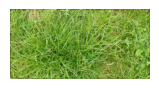

/Users/k.choi/Documents/github/csiro_git/data/train/ID1070112260.jpg


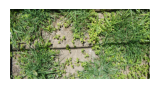

/Users/k.choi/Documents/github/csiro_git/data/train/ID1839139621.jpg


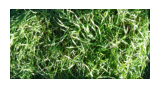

In [11]:
selected_img_path = random.sample(img_list, 100)

for img_path in selected_img_path[:3]:
    print(img_path); plt.figure(figsize=(3, 1))
    rgb_img = get_rgb(img_path)
    plt.imshow(rgb_img); plt.axis('off'); plt.tight_layout(); plt.show()

In [13]:
%%time 

features_list = []

for img_path in tqdm(selected_img_path, desc='features extraction in progress'):

    try:
        features = update_features(img_path)
    
        features['image_id'] = Path(img_path).stem
        features_list.append(features)

    except Exception as e:
        print(f"Error loading {img_path}: {e}")
        continue

features_df = pd.DataFrame(features_list)
# cols = ['image_id'] + [ col for col in features_df.columns if col != 'image_id' ]
# features_df = features_df[cols]




features extraction in progress: 100%|██████████| 100/100 [00:23<00:00,  4.17it/s]

CPU times: user 24 s, sys: 2.61 s, total: 26.6 s
Wall time: 24 s


In [14]:
%%time

metadata_df = train_df.groupby('image_id').first()[['Sampling_Date', 'State', 'Species', 'Pre_GSHH_NDVI', 'Height_Ave_cm']].reset_index()

metadata_df = pd.merge(features_df, metadata_df, on='image_id', how='left')

metadata_df.info()

metadata_df.to_csv(os.path.join(project_path + '/stats', "metadata_df.csv"), index=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 47 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   r_mean          100 non-null    float64
 1   r_median        100 non-null    float64
 2   r_std           100 non-null    float64
 3   g_mean          100 non-null    float64
 4   g_median        100 non-null    float64
 5   g_std           100 non-null    float64
 6   b_mean          100 non-null    float64
 7   b_median        100 non-null    float64
 8   b_std           100 non-null    float64
 9   green_coverage  100 non-null    float64
 10  hue_mean        100 non-null    float64
 11  hue_std         100 non-null    float64
 12  sat_mean        100 non-null    float64
 13  sat_std         100 non-null    float64
 14  val_mean        100 non-null    float64
 15  val_std         100 non-null    float64
 16  sobel_mean      100 non-null    float64
 17  sobel_std       100 non-null    floa

In [15]:
dry_df      = train_df[train_df['target_name'] == 'Dry_Total_g'][['image_id', 'target']].copy(); print(len(dry_df))
green_df    = train_df[train_df['target_name'] == 'Dry_Green_g'][['image_id', 'target']].copy(); print(len(green_df))
dead_df     = train_df[train_df['target_name'] == 'Dry_Dead_g'][['image_id', 'target']].copy(); print(len(dead_df))
clover_df   = train_df[train_df['target_name'] == 'Dry_Clover_g'][['image_id', 'target']].copy(); print(len(clover_df))
gdm_df      = train_df[train_df['target_name'] == 'GDM_g'][['image_id', 'target']].copy(); print(len(gdm_df))


dry_df      = dry_df.rename(columns={'target': 'Dry_Total_g'})
green_df    = green_df.rename(columns={'target': 'Dry_Green_g'})
dead_df     = dead_df.rename(columns={'target': 'Dry_Dead_g'})
clover_df   = clover_df.rename(columns={'target': 'Dry_Clover_g'})
gdm_df      = gdm_df.rename(columns={'target': 'GDM_g'})

complete_df = pd.merge(metadata_df, dry_df, on='image_id')
complete_df = pd.merge(complete_df, green_df, on='image_id')
complete_df = pd.merge(complete_df, dead_df, on='image_id')
complete_df = pd.merge(complete_df, clover_df, on='image_id')
complete_df = pd.merge(complete_df, gdm_df, on='image_id')

print(complete_df.columns)
print(complete_df.info())

complete_df.to_csv(os.path.join(project_path + '/stats', "complete_df.csv"), index=False)


357
357
357
357
357
Index(['r_mean', 'r_median', 'r_std', 'g_mean', 'g_median', 'g_std', 'b_mean',
       'b_median', 'b_std', 'green_coverage', 'hue_mean', 'hue_std',
       'sat_mean', 'sat_std', 'val_mean', 'val_std', 'sobel_mean', 'sobel_std',
       'canny_mean', 'canny_std', 'binary_mean', 'binary_std', 'lbp_mean',
       'lbp_std', 'lbp_0', 'lbp_1', 'lbp_2', 'lbp_3', 'lbp_4', 'lbp_5',
       'lbp_6', 'lbp_7', 'lbp_8', 'lbp_9', 'contrast', 'dissimilarity',
       'homogeneity', 'energy', 'correlation', 'ASM', 'entropy', 'image_id',
       'Sampling_Date', 'State', 'Species', 'Pre_GSHH_NDVI', 'Height_Ave_cm',
       'Dry_Total_g', 'Dry_Green_g', 'Dry_Dead_g', 'Dry_Clover_g', 'GDM_g'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 52 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   r_mean          100 non-null    float64
 1   r_median        100 non-null    flo

In [16]:
complete_df

,r_mean,r_median,r_std,g_mean,g_median,g_std,b_mean,b_median,b_std,green_coverage,...,Sampling_Date,State,Species,Pre_GSHH_NDVI,Height_Ave_cm,Dry_Total_g,Dry_Green_g,Dry_Dead_g,Dry_Clover_g,GDM_g
0,118.343473,121.0,43.417873,154.567321,161.0,43.355407,56.807031,53.0,40.486830,0.963642,...,2015/11/10,Tas,Ryegrass_Clover,0.86,7.0000,96.8288,47.7689,46.4778,2.5821,50.3510
1,115.497090,124.0,67.154238,132.866800,148.0,64.609606,83.435388,84.0,61.039042,0.758712,...,2015/1/15,NSW,Fescue_CrumbWeed,0.60,6.0000,32.0000,22.1235,9.8765,0.0000,22.1235
2,92.158828,63.0,78.260800,124.887169,108.0,74.344521,65.623581,35.0,73.111804,0.954774,...,2015/5/18,Tas,Ryegrass,0.80,8.0000,41.9157,31.5263,10.3894,0.0000,31.5264
3,144.065552,146.0,43.191199,143.928629,150.0,43.381859,78.234996,77.0,42.454115,0.483843,...,2015/11/10,Tas,Ryegrass_Clover,0.55,5.1667,58.9595,17.3410,40.1734,1.4451,18.7861
4,115.122511,116.0,48.049595,128.364253,129.0,47.243584,112.559113,114.0,46.990961,0.599698,...,2015/9/3,Tas,Ryegrass_Clover,0.57,2.3333,22.8308,20.6355,2.1953,0.0000,20.6355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,113.114553,94.0,70.519800,111.203930,95.0,71.063642,69.416084,45.0,65.579672,0.420596,...,2015/6/26,Tas,Ryegrass_Clover,0.53,2.0000,30.1575,14.2453,15.6092,0.3031,14.5484
96,116.996396,118.0,53.636626,145.158432,154.0,59.144786,109.700988,111.0,53.545689,0.899753,...,2015/4/1,NSW,Lucerne,0.83,38.0000,63.3000,63.3000,0.0000,0.0000,63.3000
97,106.936095,94.0,71.897253,132.890491,125.0,71.531346,69.540492,50.0,64.411636,0.901848,...,2015/1/15,NSW,Fescue_CrumbWeed,0.75,6.0000,44.7000,28.0322,16.6678,0.0000,28.0322
98,122.168945,126.0,51.357310,143.942500,154.0,55.769331,122.512665,128.0,52.714243,0.894986,...,2015/4/1,NSW,Lucerne,0.86,37.0000,79.1000,77.8736,1.2264,0.0000,77.8736


In [ ]:
df_total = 

In [ ]:


# highest correlated features
print('positively correlated')
print(correlation.head(5))

print('negatively correlated')
print(correlation.tail(5))

ValueError: could not convert string to float: 'ID1703304524'